<a href="https://colab.research.google.com/github/dsevero/dsevero/blob/master/content/posts/pandas/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Last updated: 01/Feb/2021

Here we will show you how to properly use the Python Data Analysis Library (pandas) and numpy. This will help you complete the current (and future) credit assignments. The agenda is:

1. How to load data from csv files
2. The basic pandas objects: DataFrames and Series
3. Handling Time-Series data
4. Resampling (optional)
5. From pandas to numpy
6. Simple Linear Regression

The following ipython magic (this is literally the name) will enable plots made by matplotlib to be rendered inside this notebook.

In [1]:
%matplotlib inline 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot') # changes the plotting style

# 1. Load data

The file `data/monthly-milk-production-pounds-p.csv` contains the average monthly milk production, in pounds, of cows from Jan/1962 to Dec/1975. More information can be found here: https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75

First, we must load this data with pandas for further analysis.

In [3]:
df = pd.read_csv('https://github.com/plotly/datasets/raw/master/monthly-milk-production-pounds.csv')

In [4]:
df.head()

,Month,Monthly milk production (pounds per cow)
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [5]:
type(df)

pandas.core.frame.DataFrame

Calling `.head()` truncates the dataset to the first 5 lines (plus the header). Notice that the type of `df` is a pandas DataFrame. This is similar to an Excel table, but much more powerful. Since pandas is a widely used library, Jupyter automatically shows the dataframe as a formatted HTML.

# 2. The basic pandas objects: DataFrames and Series

Let's take a look at each column individually.

In [6]:
df['Month'].head()

0    1962-01
1    1962-02
2    1962-03
3    1962-04
4    1962-05
Name: Month, dtype: object

In [7]:
df['Monthly milk production (pounds per cow)'].head()

0    589
1    561
2    640
3    656
4    727
Name: Monthly milk production (pounds per cow), dtype: int64

In [8]:
type(df['Month'])

pandas.core.series.Series

A pandas Series is the second basic type. In a nutshell, Series are made up of values and an index. For both columns, the index can be seen printed on the far left and the elements are `0, 1, 2, 3,` and `4`. The values are the points of interest (e.g. dates for the `Month` column and `589, 561, 640, 656` and `727` for the other).

A pandas DataFrame is made up of multiple Series, each representing a column, and an index.

The columns of a DataFrame can be accessed through slicing (as previously shown). Since the names are hard to write, we can change them like so:

In [9]:
df.columns = ['month', 'milk']

# 3. Handling Time-Series data

In [10]:
df.head()

,month,milk
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   month   168 non-null    object
 1   milk    168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


The `.info()` function gives us some insight on which data-types are being used to represent the values of each column. Notice how the `milk` column is of type `int64`. Hence, we can perform arithmetic and plotting operations like so:

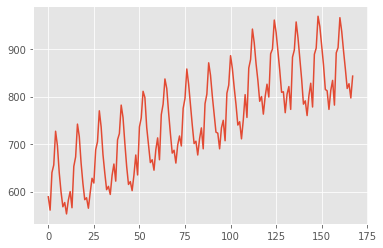

In [12]:
df['milk'].plot();

In [13]:
df['milk'].mean()

754.7083333333334

In [14]:
df['milk'].var()

10445.76472055888

The `month` column is of type `object`. This is python's way of telling you that this column is of mixed type. Hence, it is a little bit trickier to manipulate. Due to the internals of pandas, a Series that has all values of type `str` will still be refered to as of type `object`. This is the case of the `month` column.

In [15]:
df['month'].apply(type).unique()

array([<class 'str'>], dtype=object)

The `.apply` function will apply the argument function (in this case `type`) to every single element of the series. `unique` will return to us the unique values of the series (i.e. it will drop all duplicates). Calling both together let's us see what data-types are present in the Series. As can be seen, all are of type `str`.

pandas has a built-in timestamp data-type. It works like so.

In [16]:
pd.Timestamp('now')

Timestamp('2021-02-02 01:44:34.736489')

In [17]:
pd.Timestamp('1992-03-23')

Timestamp('1992-03-23 00:00:00')

In [18]:
pd.Timestamp('1992-03-23 04')

Timestamp('1992-03-23 04:00:00')

Internally, pandas stores a date as the amount of time that has passed since `1970-01-01 00:00:00`. This date is represented as `pd.Timestamp(0)`. This is useful for linear regression, since it allows us to convert timestamp data to integers without loss of reference.

In [19]:
pd.Timestamp(0)

Timestamp('1970-01-01 00:00:00')

In [20]:
pd.Timestamp('now') > pd.Timestamp('1992-03-23 04')

True

We can transform the `month` column into `pd.Timestamp` values with `pd.to_datetime` and set it as the index of a new time-series.

In [21]:
df['month'] = pd.to_datetime(df['month'])

In [22]:
s = df.set_index('month')['milk']

In [23]:
s.head()

month
1962-01-01    589
1962-02-01    561
1962-03-01    640
1962-04-01    656
1962-05-01    727
Name: milk, dtype: int64

In [24]:
s.index[0]

Timestamp('1962-01-01 00:00:00')

In [25]:
s.values[0]

589

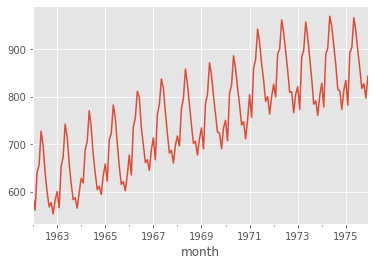

In [26]:
s.plot();

Notice how the x-axis of the above plot differs from the first one of this same section, since the index of `s` is a timestamp-like-type. The timestamp index of `s` is also manipulatable. Time-aware slices are also now available.

In [27]:
s.index.min()

Timestamp('1962-01-01 00:00:00')

In [28]:
s.index.max()

Timestamp('1975-12-01 00:00:00')

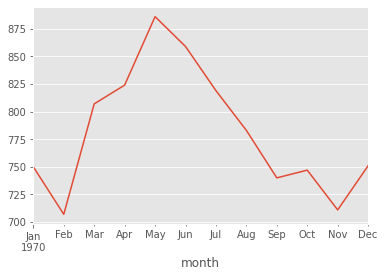

In [29]:
s['1970'].plot();

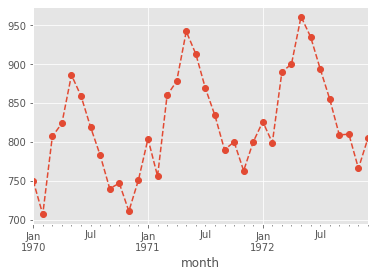

In [30]:
s['1970':'1972'].plot(style='o--');

# 4. Resampling (optional)

Looking at the plots it is pretty clear that the data trend is rising, but it fluctuates yearly reaching a local peak around June. How can we calculate the yearly mean as an attempt to smooth out the data? Luckily, `s` is a time-series (i.e. has a time index and numeric values), we can use the `.resample` function. This will allow us to group the data chronologically, given that we supply an aggregating function (i.e. `mean`, `std`, `var`, `median`, etc).

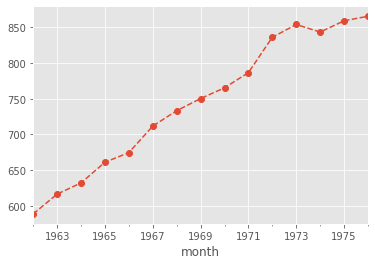

In [31]:
s.resample('12M').mean().plot(style='o--');

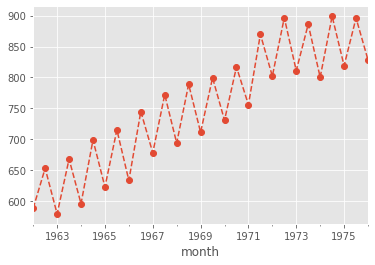

In [32]:
s.resample('6M').mean().plot(style='o--');

# 5. From pandas to numpy

Numpy provides vector data-types and operations making it easy to work with linear algebra. In fact, this works so well, that pandas is actually built on top of numpy. The values of a pandas Series, and the values of the index are numpy ndarrays.

In [33]:
type(s.values)

numpy.ndarray

In [34]:
type(s.index.values)

numpy.ndarray

In [35]:
s.head().values

array([589, 561, 640, 656, 727])

In [36]:
s.head().index.values

array(['1962-01-01T00:00:00.000000000', '1962-02-01T00:00:00.000000000',
       '1962-03-01T00:00:00.000000000', '1962-04-01T00:00:00.000000000',
       '1962-05-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [37]:
s.values.dot(s.values) # dot product

97434667

In [38]:
s.values + s.values

array([1178, 1122, 1280, 1312, 1454, 1394, 1280, 1198, 1136, 1154, 1106,
       1164, 1200, 1132, 1306, 1346, 1484, 1432, 1320, 1234, 1166, 1174,
       1130, 1196, 1256, 1236, 1376, 1410, 1540, 1472, 1356, 1278, 1208,
       1222, 1188, 1268, 1316, 1244, 1418, 1444, 1564, 1512, 1404, 1306,
       1230, 1242, 1204, 1270, 1354, 1270, 1472, 1510, 1622, 1596, 1470,
       1394, 1322, 1334, 1290, 1376, 1426, 1334, 1524, 1568, 1674, 1634,
       1534, 1444, 1362, 1374, 1320, 1396, 1434, 1392, 1550, 1592, 1716,
       1652, 1566, 1480, 1402, 1412, 1354, 1422, 1468, 1380, 1570, 1610,
       1742, 1690, 1602, 1528, 1450, 1446, 1380, 1468, 1500, 1414, 1614,
       1648, 1772, 1718, 1638, 1566, 1480, 1494, 1422, 1502, 1608, 1512,
       1720, 1756, 1884, 1826, 1738, 1668, 1580, 1600, 1526, 1600, 1652,
       1598, 1780, 1800, 1922, 1870, 1788, 1710, 1618, 1620, 1532, 1610,
       1642, 1546, 1766, 1796, 1914, 1848, 1762, 1674, 1568, 1582, 1520,
       1604, 1656, 1556, 1778, 1804, 1938, 1894, 18

In [39]:
s.values * s.values

array([346921, 314721, 409600, 430336, 528529, 485809, 409600, 358801,
       322624, 332929, 305809, 338724, 360000, 320356, 426409, 452929,
       550564, 512656, 435600, 380689, 339889, 344569, 319225, 357604,
       394384, 381924, 473344, 497025, 592900, 541696, 459684, 408321,
       364816, 373321, 352836, 401956, 432964, 386884, 502681, 521284,
       611524, 571536, 492804, 426409, 378225, 385641, 362404, 403225,
       458329, 403225, 541696, 570025, 657721, 636804, 540225, 485809,
       436921, 444889, 416025, 473344, 508369, 444889, 580644, 614656,
       700569, 667489, 588289, 521284, 463761, 471969, 435600, 487204,
       514089, 484416, 600625, 633616, 736164, 682276, 613089, 547600,
       491401, 498436, 458329, 505521, 538756, 476100, 616225, 648025,
       758641, 714025, 641601, 583696, 525625, 522729, 476100, 538756,
       562500, 499849, 651249, 678976, 784996, 737881, 670761, 613089,
       547600, 558009, 505521, 564001, 646416, 571536, 739600, 770884,
      

The above examples are just for show. You can do the same thing directly with pandas Series objects and it will use numpy behind the scenes.

In [40]:
s.dot(s) == s.values.dot(s.values)

True

# 6. Simple Linear Regression.

Side note: python accepts non-ascii type characters. So it is possible to use greek letters as variables. Try this: type in `\alpha` and press the TAB key in any cell.

In [41]:
α = 1
β = 2
α + β

3

Here we will implement a simple linear regression to illustrate the full usage of pandas with numpy. For a single variable with intercept: $y = \alpha + \beta x$, the closed form solution is: 

$$\beta = \frac{cov(x,y)}{var(x)}$$
$$\alpha = \bar{y} - \beta \bar{x}$$

where $\bar{y}$ and $\bar{x}$ are the average values of the vectors $y$ and $x$, respectively.


In [42]:
y = s
x = (s.index - pd.Timestamp(0)).days.values

In [43]:
β = np.cov([x,y])[0][1]/x.var()
α = y.mean() - β*x.mean()

In [44]:
α

776.0355721497116

In [45]:
β

0.05592981987998409

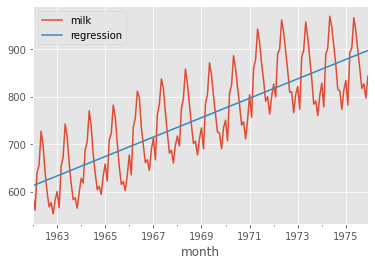

In [46]:
(
    s
    .to_frame() # transforms s back into a DataFrame
    .assign(regression = α + β*x) # creates a new column called regression with values α + β*x
    .plot() # plots all columns
);

The above programming style is called method chaining, and is highly recommended for clarity.